<a href="https://colab.research.google.com/github/y001003/dacon/blob/main/energy/%EC%A0%84%EB%A0%A5%EC%82%AC%EC%9A%A9%EB%9F%89_%EC%98%88%EC%B8%A1(%EC%8B%A4%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 분석에 필요한 라이브러리를 불러옵니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
train = pd.read_csv('/content/drive/MyDrive/project/energy/train.csv', encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/project/energy/test.csv', encoding='cp949')
submission = pd.read_csv('/content/drive/MyDrive/project/energy/sample_submission.csv', encoding='cp949')

## column별 설명
- num : 건물 번호 (1 ~60)
- date_time : 시간 단위
- 전력사용량(kwh) : 시간당 전력사용량(target)
- 기온, 풍속, 습도, 강수량, 일조 : 기상 정보 (시간당)
- 비전기냉방설비운영, 태양광보유 : categorical feature( 0 / 1 )(건물정보)


In [4]:
#Q. 122400의 의미는? 85 x 60 x 24 || 2020-06-01 - 2020-08-24 (85일), 24시간, 60개 건물
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


### column별 설명
|Column|설명|
|---|---|
|num|건물번호(1 ~ 60)|
|data_time|시간 단위|
|전력사용량(kWh)|시간당 전력사용량 (target)|
|기온(°C)|시간당 기온|
|풍속(m/s|시간당 풍속|
|습도(%)|시간당 습도|
|강수량(mm)|6시간당 강수량|
|일조(hr)|3시간당 일조|
|비전기냉방설비운영|건물 정보 (1/0)|
|태양광보유|건물 정보 (1/0)|

In [5]:
# Q. 10080은?
test 

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# column 이름 변경
train.columns = ["num", "date_time", "target", "temperature",
                "windspeed", "humidity", "precipitation",
                "insolation", "nelec_cool_flag", "solar_flag"]
test.columns = ["num", "date_time", "temperature",
                "windspeed", "humidity", "precipitation",
                "insolation", "nelec_cool_flag", "solar_flag"]

## 2. 데이터 전처리

데이터 전처리시, 무조건 해야하는 것. No optional

- 결측치 처리 : 결측치를 채우거나, 지우거나해서 없애야 한다.
- categorical featrue 처리 : object형 column은 무조건 숫자로 변환

### 2-1. 결측치 처리

테스트 데이터에 `temperature, windspeed, humidity, precipitation,insolation, nelec_cool_flag,solar_flag` 란에 결측치가 존재한다.

>- `nelec_cool_flag, solar_flag` 는 train 데이터의 정보를 가지고 결측치를 채운다.(건물에 설치된 부속 시설물이 일주일만에 사라진다고 보기는 어렵다.)
>- `temperature, windspeed, humidity, precipitation,insolation` 는 pd.series.interpolate 메서드를 사용하여 결측치를 채운다.

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   date_time        10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  2296 non-null   float64
 8   solar_flag       1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


#### 2_1_1 건물 번호(num)를 이용하여 `nelec_cool_flag, solar_flag` 결측치 채우기

##### 건물 정보

In [9]:
#건물별로 '비전기냉방설비운영'과 '태양광보유'를 판단해 test set의 결측치를 보간해줍니다
train[["num", "nelec_cool_flag", "solar_flag"]].drop_duplicates() # 건물별로 정보가 똑같다.

,num,nelec_cool_flag,solar_flag
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0
10200,6,0.0,0.0
12240,7,1.0,0.0
14280,8,1.0,1.0
16320,9,0.0,1.0
18360,10,1.0,0.0


##### 건물번호별(num) 별 시설물 여부 데이터 가져오기

In [10]:
building_info = train[["num", "nelec_cool_flag", "solar_flag"]].drop_duplicates()
building_info

,num,nelec_cool_flag,solar_flag
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0
10200,6,0.0,0.0
12240,7,1.0,0.0
14280,8,1.0,1.0
16320,9,0.0,1.0
18360,10,1.0,0.0


##### test 데이터에 train 의 시설물여부 데이터 덮어씌우기

In [11]:
# JOIN?
test = test.drop(columns=["nelec_cool_flag", "solar_flag"])
test = pd.merge(test,building_info, on=["num"])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   date_time        10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  10080 non-null  float64
 8   solar_flag       10080 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 787.5+ KB


#### 2_1_2 기상 정보 강수량,일조량,풍속,기온,습도 (insolation)

##### interpolate 메서드 확인

In [12]:
# 가장 최근에 기록된 정보로 채워줍니다.
# interpolate method
test.temperature.interpolate(method="pad") # pad: 앞에 있는 것을 이용하여 채워준다.
test.temperature.interpolate(method="linear") # linear: 선형 보간법
test.temperature.interpolate(method='quadratic')

0        27.800000
1        27.806027
2        27.639360
3        27.300000
4        26.787947
           ...    
10075    28.679729
10076    28.313063
10077    27.900000
10078          NaN
10079          NaN
Name: temperature, Length: 10080, dtype: float64

In [13]:
test.insolation.value_counts()

0.0    1872
0.1     120
3.0     102
0.6      83
0.2      74
0.9      71
0.5      63
1.0      62
1.2      60
0.3      57
1.6      55
2.7      54
1.8      53
0.4      49
1.1      49
2.8      46
2.4      45
1.4      42
1.3      40
2.2      40
0.7      39
0.8      37
2.0      36
2.9      35
2.1      29
1.5      29
2.6      26
1.9      26
1.7      25
2.3      24
2.5      17
Name: insolation, dtype: int64

##### interpolate 메서드 방법 비교
pad, linear, quadratic 중 어떤 방법을 사용해서 결측치를 채울 것인가 비교하기

방법  
1. train 데이터에서 test데이터와 같은 형태로 결측치를 가진 dummy 데이터를 만든다.
2. dummy 데이터와 train 데이터 사이의 error가 가장 작은 방법을 선택한다.

In [14]:
dummy = train.copy() # 실험용 train data를 하나 복사합니다.

In [15]:
# 내 답안
# 스펀지 만들기
# dummy를 test data처럼 빈 칸 뚫기 
# (풍속, 기온, 일조량, 습도 3간마다 데이터 존재, 강수량은 6칸마다 데이터 존재)
def make_train_nan(data, columns, n):
    # data : 스펀지를 만들 원본 dataframe
    # column은 스펀지를 만들 대상 column
    # n : 몇번째마다 값을 둘 것인가 (3 or 6)
    for i in range(len(data.columns)):
        if i % n != 0 :
            
            data[columns].iloc[i] = np.nan
    
    
    

make_train_nan(dummy, 'temperature', 3)
# make_train_nan(dummy, [], 6)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
# 모범 답안
# 스펀지 만들기
# dummy를 test data처럼 빈 칸 뚫기 
# (풍속, 기온, 일조량, 습도 3간마다 데이터 존재, 강수량은 6칸마다 데이터 존재)
def make_train_nan(data, columns, n):
    # data : 스펀지를 만들 원본 dataframe
    # column은 스펀지를 만들 대상 column
    # n : 몇번째마다 값을 둘 것인가 (3 or 6)

    # 1. mask와 for 문 사용
    mask = [i % n != 0 for i in range(len(data)) ]
    data.loc[mask,columns] = np.nan
    
    # 2. pandas numpy board casting
    # data.loc[data.index % n != 0, columns] = np.nan

make_train_nan(dummy, ['humidity','temperature','insolation','windspeed'], 3)
make_train_nan(dummy, ['precipitation'], 6)
dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   num              122400 non-null  int64  
 1   date_time        122400 non-null  object 
 2   target           122400 non-null  float64
 3   temperature      40800 non-null   float64
 4   windspeed        40800 non-null   float64
 5   humidity         40800 non-null   float64
 6   precipitation    20400 non-null   float64
 7   insolation       40800 non-null   float64
 8   nelec_cool_flag  122400 non-null  float64
 9   solar_flag       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [17]:
dummy['temperature']

0         17.6
1          NaN
2          NaN
3         17.1
4          NaN
          ... 
122395     NaN
122396     NaN
122397    27.3
122398     NaN
122399     NaN
Name: temperature, Length: 122400, dtype: float64

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def compare_interpolation_methods(train, dummy, column, methods, metric):
    # e.g. column == "windspeed"
    # train, dummy : 비교 대상
    # column : 비교 대상에 해당하는 column
    # methods : interpolation methods ("pad","linear","quadratic")
    # metric : 비교를 하는 기준 (MAE, MSE)
    error_dict = {}

    for method in methods:
        if method == "quadratic":
            temp = dummy[column].interpolate(method=method).interpolate("linear") # 마지막에 비어있는 NaN 채우기
            error_dict[method] = metric(train[column], temp) # error를 계산
        else :
            temp = dummy[column].interpolate(method=method) # 특정 column을 주어진 방식으로 interpolate
            error_dict[method] = metric(train[column], temp) # error를 계산    
    return error_dict
compare_interpolation_methods(train, dummy, 'humidity', ['pad','linear','quadratic'], mean_squared_error)

{'linear': 5.530951978939724,
 'pad': 21.611516339869283,
 'quadratic': 5.433766159300832}

In [19]:
# 1. interpolation 기법별로 에러(틀린 정도)를 계산합니다.
all_error_dict = {}
metric = mean_absolute_error
for column in ['humidity','temperature','insolation','windspeed','precipitation']:
    methods = ['pad','linear','quadratic']
    error_dict = compare_interpolation_methods(train,dummy, column, methods, metric)
    all_error_dict[column] = error_dict
# 2. 계산 결과를 그래프로 그립니다.
all_error_df = pd.DataFrame(all_error_dict)
all_error_df

,humidity,temperature,insolation,windspeed,precipitation
pad,2.544775,0.552264,0.073680,0.443193,0.537618
linear,1.297897,0.219766,0.048181,0.346830,0.451359
quadratic,1.291286,0.209853,0.056955,0.367535,0.503410


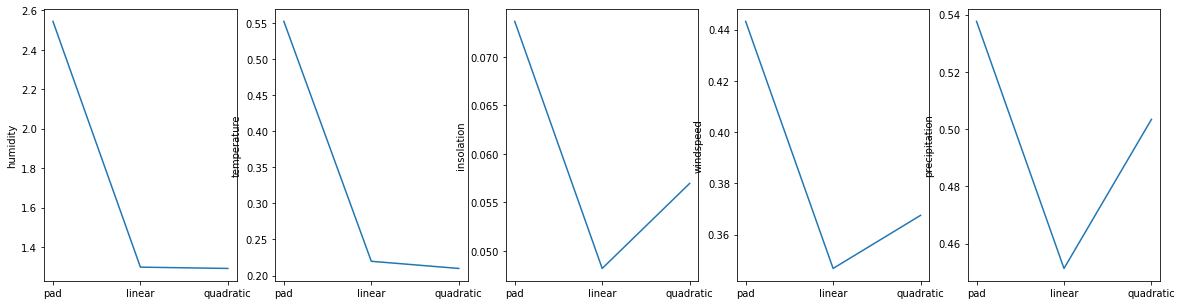

In [ ]:
fig, axes = plt.subplots(1, 5, figsize = (20, 5))
for i in range(len(all_error_df.columns)):
    sns.lineplot(ax=axes[i], data=all_error_df.iloc[:, i].transpose(), sort=False)

In [ ]:
# 테스트 데이터에 결측치를 채워봅니다!
test.temperature = test.temperature.interpolate(method="quadratic")
# 마지막 NaN을 채우기 위해서 linear interpolation을 적용해줍니다.
test.temperature = test.temperature.interpolate(method="linear")

test.windspeed = test.windspeed.interpolate(method="linear")

test.humidity = test.humidity.interpolate(method="quadratic")
# 마지막 NaN을 채우기 위해서 linear interpolation을 적용해줍니다.
test.humidity = test.humidity.interpolate(method="linear")

test.precipitation = test.precipitation.interpolate(method="linear")

test.insolation =test.insolation.interpolate(method="linear")

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   date_time        10080 non-null  object 
 2   temperature      10080 non-null  float64
 3   windspeed        10080 non-null  float64
 4   humidity         10080 non-null  float64
 5   precipitation    10080 non-null  float64
 6   insolation       10080 non-null  float64
 7   nelec_cool_flag  10080 non-null  float64
 8   solar_flag       10080 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 787.5+ KB


In [ ]:
#요일 변수를 추가해봅니다.
def weekday(x):


+ test 결측치를 채워봅니다.
+ test 데이터의 변수는 예보 데이터이며, 예보 데이터는 train 데이터의 기간에 생성된 것이기에 활용 가능합니다.

1) 평균으로 채우기


2) 최빈값으로 채우기


3) 근처(앞, 뒤)에 있는 값으로 채우기


4) interpolation

### 2-2. 상관관계 분석

In [ ]:
# 피처간 비슷한 변수들이 있는지 확인하기 위해 상관관계 분석을 수행합니다.


In [ ]:
# heatmap


In [ ]:
# 피처간 비슷한 변수들이 있는지 확인하기 위해 상관관계 분석을 수행합니다.
corr = []
for num in range(1,61):
    df = train[train.num==num]
    num_corr = df.corr()['target']
    num_corr = num_corr.drop(['num','nelec_cool_flag','solar_flag','target'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,61))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("Correlation between features and target", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('Building(num)')
plt.show()

### 2-3. 이상치 검출

1) IQR(Inter-Quantile Range)


2) Outlier Detection method (e.g. Isolation Forest)

### IQR 

In [ ]:
# 데이터 중에 전체 데이터의 패턴을 벗어나는 데이터가 있는지 확인합니다.
def get_outlier(data, column, weight=1.5):
    

    
    
    print("IQR은 %.2f이다." % IQR)
    print(f"lower_bound는 {lower_bound:.2f}이다.") # f-string
    print("upper_bound는 {:.2f}이다.".format(upper_bound))
    

    return outlier_idx

In [ ]:
selected_col = input("Which column ? ")
outlier_idx = get_outlier(train, selected_col)
train.loc[outlier_idx, :]

In [ ]:
# outlier detection
# anomaly detection

train.drop(outlier_idx)

### Isolation Forest (ML Model)

In [ ]:
from sklearn.ensemble import IsolationForest

X = train.drop(columns=["num", "date_time", "target"])

model = 

In [ ]:
# IsolationForest로 판단한 outlier들을 제거합니다


## 3. 예측 모델 구현

In [ ]:
# 전력사용량 예측을 위해 회귀 모델을 불러옵니다
from lightgbm.sklearn import LGBMRegressor

In [ ]:
train

,num,date_time,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [ ]:
# 학습에 필요한 데이터셋을 만듭니다
X = train.drop(columns=["num","date_time","target"])
y = train.target

In [ ]:
# 학습 및 모델 검증을 위해 KFold Cross Validation 기법을 사용합니다.


In [ ]:
# training
reg = LGBMRegressor()
reg.fit(X,y)
pred = reg.predict(X)
mean_absolute_error(y, pred)


1220.6470444592926

In [ ]:
# submission 파일 생성
X_test = test.drop(columns=['num','date_time'])
output = reg.predict(X_test)

In [ ]:
submission["answer"] = output
submission.to_csv("submission.csv",index=False)